# 1. Introduction
Jupyter notebook used for University Of Leeds MSc Artificial Intelligence module OCOM5300M.

This is the implementation of Qwen2-VL-7B as primary VLM in an embodied agent for the VLN-CE task.

Please see associated paper for motivation, implementation details, and comparison of results.

# 2. Setup
This section is used to set up the workbook by:
1. Importing required modules
2. Establishing Folder Paths and Directories
3. Defining required functions

## 2.1 Setup: Required module imports

In [2]:
# Required imports
import os
import json
import numpy as np
import pandas as pd
import random
import magnum as mn
from PIL import Image
from matplotlib import pyplot as plt
import textwrap
import math
import cv2
import copy
import re
from datetime import datetime
import pickle
import gc
import magnum as mn
import quaternion
from quaternion import from_rotation_vector
from itertools import cycle

# Habitat-sim related imports
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps

# VLM and LLM related imports
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from transformers import AutoTokenizer, AutoProcessor, AutoModelForVision2Seq
from awq.models.qwen2vl import Qwen2VLAWQForConditionalGeneration
from qwen_vl_utils import process_vision_info
from openai import OpenAI
from accelerate import Accelerator
import ast

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


## 2.2 Setup: Directory paths and filenames

In [3]:
# Core home/root folder paths
habitat_dir_path = "/home/wes/habitat/data/"                                        # path to habitat-sim root directory
rxr_data_path = "/media/wes/Lexar/rxr_data/rxr-data/"                               # path to room-across-room data directory
training_dir_path = "/home/wes/Documents/training_trajectories/"                    # trajectories, reasoning, and actions used as finetuning data
output_dir_path = "/home/wes/Documents/outputs/"                                    # path to model outputs

# Folder paths based on root folder paths
scan_dir_path = os.path.join(habitat_dir_path, f"scene_datasets/mp3d/")             # directory of habitat-sim scenes
pose_dir_path = os.path.join(rxr_data_path, f'pose_traces/rxr_train/')              # directory of the RxR training poses
test_pose_dir_path = os.path.join(rxr_data_path, f'pose_traces/rxr_val_unseen/')    # directory of the RxR testing poses
mp3d_scene_config = os.path.join(scan_dir_path, f"mp3d.scene_dataset_config.json")  # filepath of Matterport 3D scene configuration file

scan_path = '' # declaring global variable for updating scene path as we iterate from scene-to-scene

training_annotations_fname = "rxr_train_guide.jsonl/rxr_train_guide.json"           # filepath to the training annotations provided by RxR
training_annotations_path = os.path.join(rxr_data_path, training_annotations_fname) # full filepath to training annotations provided by RxR

testing_annotations_fname = "rxr_val_unseen_guide.jsonl/rxr_val_unseen_guide.json"  # filepath to the validation (unseen) annotations provided by RxR
testing_annotations_path = os.path.join(rxr_data_path, testing_annotations_fname)   # full filepath to validation (unseen) annotations provided by RxR

# checking that paths exist
print(f'Exists: {os.path.exists(scan_dir_path)} \t scan_dir_path: {scan_dir_path}')
print(f'Exists: {os.path.exists(pose_dir_path)} \t pose_dir_path: {pose_dir_path}')
print(f'Exists: {os.path.exists(pose_dir_path)} \t pose_dir_path: {test_pose_dir_path}')
print(f"Exists: {os.path.exists(mp3d_scene_config)} \t mp3d_scene_config: {mp3d_scene_config}")

Exists: True 	 scan_dir_path: /home/wes/habitat/data/scene_datasets/mp3d/
Exists: True 	 pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/
Exists: True 	 pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_val_unseen/
Exists: True 	 mp3d_scene_config: /home/wes/habitat/data/scene_datasets/mp3d/mp3d.scene_dataset_config.json


In [4]:
model_path_base = "Qwen/Qwen2-VL-7B-Instruct"
model_path_lora = "/home/wes/Documents/Qwen2-VL-7B_VLN-LoRA-merged/"
model_path_qlora = "/home/wes/Documents/Qwen2-VL-7B_VLN-AWQ-4bit/"

vlm_models = {"Base": model_path_base,
              "LoRA": model_path_lora,
              "QLoRA": model_path_qlora}

## 2.3. Setup: Declaration of global variables 

In [5]:
# Global simulator variables for use across multiple functions
cfg = None
sim = None

In [6]:
# Default angles for each 'sensor' available for use to observe the environment
# Each observation is created by rotating the single color camera on the agent agent by a set angle
view_rotations = {
    "forward": 0.0,
    "forward-right": -math.pi/4,
    "right": -math.pi/2,
    "behind": math.pi,
    "forward-left": math.pi/4,
    "left": math.pi/2
}

## 2.4 Setup: Utility functions

### 2.4.1 Setup: Update Functions - Updates to file paths, saving and loading files

In [7]:
# Returns the full filepath of a scene given a scene id (i.e. scan id)
def get_scan_path(scene_id):
    global scan_dir_path
    return os.path.join(scan_dir_path, f"{scene_id}/{scene_id}.glb")

In [8]:
# Propagate the new scene filepath across all relevant dictionaries, etc.
def update_scan_path(scene_id):
    global scan_dir_path
    global sim_settings
    
    scan_path = get_scan_path(scene_id)
    sim_settings['scene'] = scan_path

    return

In [9]:
# Saves the outputs / results in a pickle file
def save_results(data, dir_path, fname):
    fpath = dir_path + fname + '.pkl'
    print(f'Saving to: {fpath}')
    if isinstance(data, pd.DataFrame):
        data.to_pickle(fpath)
    else:
        with open(fpath, 'wb') as file:
            pickle.dump(data, file)
    return

In [10]:
# Loads a file
def load_results(filepath, open_mode='rb'):
    output = None
    if os.path.exists(filepath):
        with open(filepath, open_mode) as file:
            output = pickle.load(file)
            print(f"File loaded: {filepath}")
    else:
        print(f"File not found: {filepath}")

    return output

### 2.4.2 Setup: Utility Functions - Displaying Observations

In [11]:
# Displaying a single sample of an observation
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb", "depth"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

# Function to create a video when in Continuous Environment
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

In [12]:
# Retrieves an agent's current observations from its color sensors
def get_current_observations(agent, directions=None):
    agent_views = dict()
    original_state = agent.get_state()
    new_state = habitat_sim.AgentState()
    color_observations = []

    # Default observations are in 90 degree rotations
    if directions is None:
        directions = {
            "forward": 0.0,
            "left": math.pi/2,
            "right": -math.pi/2,
            "behind": math.pi
        }
    
    for direction, angle in directions.items():
        rotation_quat = from_rotation_vector([0, angle, 0])
        new_orientation = original_state.rotation * rotation_quat
        
        # Rotating the agent
        new_state.position = original_state.position
        new_state.rotation = new_orientation
        agent.set_state(new_state)
        
        # Getting the observations
        observations = sim.get_sensor_observations()
        color_observations.append(observations["color_sensor"])
        agent_views[direction] = observations["color_sensor"]
        
    # Returning agent to original orientation
    agent.set_state(original_state)

    return agent_views, color_observations

In [13]:
# Function to create basic forward-centred panoramic image
def get_current_panorama(agent, number_of_captures = 5):
    rotation_size = 360/number_of_captures
    initial_orientation = agent.get_state().rotation
    
    pano_observations = []

    for i in range(number_of_captures + 1):  # +1 to return agent back to original orientation
        agent_state = agent.get_state()
        rotation_amount = habitat_sim.utils.quat_from_angle_axis(
            np.deg2rad(-rotation_size * i), np.array([0,1,0]) # Clockwise rotation about the Y-axis
        )
        agent_state.rotation = initial_orientation * rotation_amount
        
        agent.set_state(agent_state)
        observations = sim.get_sensor_observations()
        pano_observations.append(observations["color_pano_sensor"])

    pano_observations = pano_observations[:-1]
    
    return cv2.hconcat(pano_observations[-2:] + pano_observations[:-2])

### 2.4.3 Setup: Utility Functions - Configure Habitat-Sim Simulator Settings

In [14]:
# Setting up default sim settings
rgb_sensor = True
depth_sensor = True
semantic_sensor = False
seed = 1
number_images_for_panorama = 4 # number of images required for a full 360 degree panorama to be created

sim_settings = {
    "width": 64,  # Spatial resolution of the observations
    "height": 64,
    "scene": scan_path,  # Scene path
    "scene_dataset": mp3d_scene_config,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.4,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": seed,  # used in the random navigation
    "enable_physics": False,  # kinematics only    
    "hfov" : 90, #360 / number_images_for_panorama
    "step_size" : 1.0 # metres moving forward
}

sensor_height_adjustment = np.array([0, -sim_settings["sensor_height"], 0])

In [15]:
# Success criteria and maximum number of steps allowed in each trajectory (to limit experience time)
min_waypoint_distance = sim_settings["step_size"] / 2
min_goal_distance = 1.0
max_steps = 50

In [16]:
# Creates a simulator based on the simulator settings specified in sim_settings
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    sensor_specs = []

    # RGB sensor specs: used for colour observations for the agent
    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(color_sensor_spec)

    # RGB panorama sensor specs: used to create a 360 degree panorama, with "forward" as centre image
    color_sensor_pano_spec = habitat_sim.CameraSensorSpec()
    color_sensor_pano_spec.uuid = "color_pano_sensor"
    color_sensor_pano_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_pano_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_pano_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_pano_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_pano_spec.hfov = 360/5
    sensor_specs.append(color_sensor_pano_spec)

    # Depth sensor specs
    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    depth_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(depth_sensor_spec)

    # Agent movement: Predefined agent movements
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward" : habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=settings["step_size"])
        ),
        "turn_left":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_right":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_around":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=180.0)
        ),
        "turn_forwardleft":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=45.0)
        ),
        "turn_forwardright":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=45.0)
        )

    }
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


### 2.4.4 Setup: Utility Functions - Map agent position to a topdown map of the environment

In [17]:
# Convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel = 0.025):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# Display a topdown map with matplotlib
def display_map(topdown_map, key_points=None, gold_path=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    
    # plot points visited
    if key_points is not None:
        xs = np.array([point[0] for point in key_points])
        ys = np.array([point[1] for point in key_points])
        plt.plot(xs, ys, marker="o", markersize=6, alpha=0.6, color='lightsteelblue')

    # plot points visited in the provided by 'gold label' RxR data
    if gold_path is not None:
        xs = np.array([point[0] for point in gold_path])
        ys = np.array([point[1] for point in gold_path])
        plt.plot(xs, ys, marker="x", markersize=4, linestyle='dashed', linewidth=1, alpha=0.5, color='gold')
    
    plt.show()
    return

In [18]:
# Draw the map of the current scene
def draw_map(agent, scene_id, meters_per_pixel = 0.025, height = 1, agent_radius_px = 8):
    #print(f"Showing map for scene: {scene_id}")
    #print(f"The NavMesh bounds are: {str(sim.pathfinder.get_bounds())}")
    
    agent_pos = agent.get_state().position
    agent_forward = utils.quat_to_magnum(agent.get_state().rotation).transform_vector(mn.Vector3(0,0,-1.0))
    agent_orientation = math.atan2(agent_forward[0], agent_forward[2])

    topdown_map = maps.get_topdown_map(
        sim.pathfinder, height=agent_pos[1], meters_per_pixel = meters_per_pixel
    )
    recolor_map = np.array(
        [[255,255,255],[128,128,128], [0,0,0]], dtype=np.uint8
    )
    topdown_map = recolor_map[topdown_map]

    grid_dimensions = (topdown_map.shape[0], topdown_map.shape[1])
    agent_grid_pos = maps.to_grid(agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder)
    maps.draw_agent(topdown_map, agent_grid_pos, agent_orientation, agent_radius_px=agent_radius_px)

    return topdown_map

In [19]:
# Shows the map and trajectory taken for a particular trajectory
def show_trajectory(scan_id, instruction_id, trajectory_agent_states, gold_path_positions):
    global cfg
    global sim
    
    try:
        sim.close()
    except:
        pass

    update_scan_path(scan_id)
    cfg = make_cfg(sim_settings)
    sim = habitat_sim.Simulator(cfg)
    agent = sim.get_agent(0)

    trajectory_positions, trajetory_rotations = zip(
        *[(state.position, state.rotation) for state in trajectory_agent_states]
    )

    agent_state = habitat_sim.AgentState()
    agent_state = snap_to_point(agent_state, trajectory_positions[-1], trajetory_rotations[-1])
    agent.set_state = agent_state

    topdown_map = draw_map(agent, scan_id)
    trajectory = convert_points_to_topdown(sim.pathfinder, trajectory_positions)
    gold_path = convert_points_to_topdown(sim.pathfinder, gold_path_positions)

    display_map(topdown_map, key_points=trajectory, gold_path=gold_path)

    sim.close()

    return

### 2.4.5 Setup: Utility Funtions - Reading and loading RxR data

In [20]:
# Utility function to read RxR data and return it as a dataframe
def json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))

    return pd.DataFrame(data)    

In [21]:
# Takes a scan id (aka: scene_id) and annotation file path
# Returns a list of scene_ids and associated instruction_ids and instructions
# If scan_id is provided, then only annotations and instruction ids for the scene_id is returned
def get_rxr_annotations(annotations_path, scan_id_list = 'None'):
    if not os.path.exists(annotations_path):
        print(f'Annotation path not found: {annotations_path}')
        return

    n_records = 0
    rxr_annotations = {}
    # Turning entire annotation json into dataframe
    df_rxr = json_to_df(annotations_path)
    
    # Focusing on just the english instructions for now
    df_rxr = df_rxr[df_rxr['language']=='en-US']

    # If no scan_id provided, go through entire dataset
    if scan_id_list == 'None':
        scan_id_list = df_rxr['scan'].unique().tolist()

    # Creates a dictionary that matches instructions and scenes
    # key = scan_id
    # value = [{instruction_id}:{instructions}, ...]
    for scan_id in scan_id_list:
        rxr_annotations[scan_id] = df_rxr[df_rxr['scan']==scan_id][['instruction_id', 'instruction']].to_dict('records')
        n_records += len(rxr_annotations[scan_id])

    return scan_id_list, rxr_annotations, n_records

In [22]:
# Takes an instruction_id and returns the pose trace
# Pose trace: the list of positions (and rotations) along the gold path
def get_pose_trace(pose_dir_path, instruction_id):
    instruction_id = ('000000' + str(instruction_id))[-6:] # Appending zeros to match file name nomenclature
    pose_trace_path = os.path.join(pose_dir_path, f'{instruction_id}_guide_pose_trace.npz')
    if not os.path.exists(pose_trace_path):
        print(f'pose_trace_path not found: {pose_trace_path}')
        return

    pose_trace = np.load(pose_trace_path)['extrinsic_matrix']
    return pose_trace

In [23]:
# Takes a pose trace dataset and returns a list of all unique positions
#  and a list of the rotation based on that unique position
def get_unique_poses(pose_trace):
    unique_position_list = np.zeros((1,3))
    unique_rotation_list = np.zeros((1,3,3))
    for pose in pose_trace:
        if not np.all(np.isin(np.round(pose[:3,3], 2), unique_position_list)):
            unique_position_list = np.append(unique_position_list, np.round(np.array(pose[:3,3]), 2).reshape(1,3), axis=0)  # position can be rounded to account for slight offsets during image capture
            unique_rotation_list = np.append(unique_rotation_list, np.array(pose[:3,:3]).reshape(1,3,3), axis=0) # rotation should not be rounded to maintain precise viewing angles

    return np.squeeze(unique_position_list[1:]), unique_rotation_list[1:]

### 2.4.6 Setup: Utility Functions - Generate outputs from VLM and LLM

In [24]:
def create_vlm(model_type=None):
    global model_vlm_1
    global processor_vlm_1

    try:
        model_vlm_1.to('cpu')
        del model_vlm_1
        torch.cuda.empty_cache()
        gc.collect()
    except:
        pass

    if model_type is None or model_type == 'Base':
        processor_vlm_1 = AutoProcessor.from_pretrained(model_path_base)
        model_vlm_1 = Qwen2VLForConditionalGeneration.from_pretrained(
            model_path_base,
            torch_dtype=torch.bfloat16,
            attn_implementation="flash_attention_2",
            device_map="auto"
        )
    
    elif model_type == 'LoRA':
        processor_vlm_1 = Qwen2VLProcessor.from_pretrained(model_path_lora)
        model_vlm_1 = Qwen2VLAWQForConditionalGeneration.from_pretrained(
            model_path=model_path_lora,
            model_type="qwen2_vl",
            use_cache=False,
            attn_implementation="flash_attention_2"
        )
        
    elif model_type == "QLoRA":
        processor_vlm_1 = Qwen2VLProcessor.from_pretrained(model_path_qlora)
        model_vlm_1 = Qwen2VLAWQForConditionalGeneration.from_pretrained(
            model_path=model_path_qlora,
            model_type="qwen2_vl",
            use_cache=False,
            attn_implementation="flash_attention_2"
        )
    
    model_vlm_1.to("cuda")

In [25]:
def generate_outputs_qwen2(model, processor, messages, max_tokens=128):
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, add_vision_id=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
            text = [text],
            images = image_inputs,
            videos = video_inputs,
            padding = True,
            return_tensors = "pt",
        )
    
    inputs = inputs.to("cuda")
    
    generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return output_text[0]

In [26]:
def generate_outputs_openai(client, messages, model="gpt-4o-mini"):
    completion = client.chat.completions.create(
        model = model,
        messages = messages
    )
    
    return completion.choices[0].message.content

### 2.4.7 Setup: Utility Functions - Agent-Environment Interaction

In [27]:
# Direct the agent to take a specific action
def take_action(agent, action):
    if action != 'Goal':
        action_dict = {
            "Forward" : "move_forward",
            "Left" : "turn_left",
            "Right" : "turn_right",
            "Behind" : "turn_around",
            "Forward-left" : "turn_forwardleft",
            "Forward-right" : "turn_forwardright"
        }
    
        agent.act(action_dict[action])

In [28]:
# Takes in a position and rotation state and returns an agent state
def snap_to_point(agent_state, agent_position, agent_rotation):
    # Turn rotation matrix into a quaternion
    if isinstance(agent_rotation, quaternion.quaternion):
        agent_rotation_quat = agent_rotation
        agent_state.rotation = agent_rotation
    else:
        agent_rotation_quat = mn.Quaternion.from_matrix(mn.Matrix3(agent_rotation))
        agent_state.rotation = utils.quat_from_magnum(agent_rotation_quat)  # Turn magnum quaternion into habitat-sim quaternion

    agent_state.position = agent_position
    
    return agent_state

In [29]:
# Checking to see if the agent can move forward without a collision
# Acts as a proxy for taking in laser-scanned distances
# Takes as input:
#    1) The agent
#    2) The direction (in radians) to check in, where 0.0 is forward
#    3) The error margin (in metres) that the closest snap_point can be to
#        the intended_pos and still be considered a navigable point
def check_step_collision(agent, direction=0.0, error_radius=0.05):
    agent_state = agent.get_state()
    current_pos = agent_state.position
    agent_forward = utils.quat_to_magnum(
            agent_state.rotation
        ).transform_vector(mn.Vector3(0, 0, -1.0))
      
    direction_vector = mn.Quaternion.rotation(mn.Rad(direction), mn.Vector3(0, 1, 0)).transform_vector(agent_forward)
    
    intended_pos = current_pos + direction_vector * sim_settings["step_size"]
    is_navigable = sim.pathfinder.is_navigable(intended_pos)
    
    # Checking if a snapped point would be within a small margin of the intended_pos
    #  We will allow this snapped point to take the place of the intended_pos if
    #  the snapped point is within a small error margin - this avoids instances
    #  of a navigable point (with environment sliding enabled) being ruled un-navigable
    #  if it is only off by a small margin
    snapped_intended_pos = sim.pathfinder.snap_point(intended_pos)
    euclidean_distance = np.linalg.norm(
        intended_pos[[0,2]] - snapped_intended_pos[[0,2]]
    )
    #print(f'Euclidean Distance to snap_point: {euclidean_distance}')

    if not is_navigable and euclidean_distance <= error_radius:
        #print(f'Using snapped point instead')
        intended_pos = snapped_intended_pos
        is_navigable = True
    
    #print(f"check_step_collsion - direction: {direction}")
    #print(f'Intended position is navigable? {is_navigable}')
    
    return is_navigable, intended_pos

### 2.4.8 Setup: Utility Functions - Reporting on Performance

In [30]:
# Finds and returns the geodesic distance between two points
#  in the environment. Returns "null" if no path found
def find_geodesic_distance(agent_positions, gold_end_pos):
    distances = []
    paths = []
    path = habitat_sim.ShortestPath()

    if not(isinstance(agent_positions, list)):
        agent_positions = list(agent_positions)

    for position in agent_positions:
        # setting agent position to same height as used in dataset
        path.requested_start = np.array(
            [
                position[0],
                gold_end_pos[1],
                position[2]
            ]
        )
        path.requested_end = gold_end_pos
        found_path = sim.pathfinder.find_path(path)
        
        paths.append(path.points)
        distances.append(path.geodesic_distance)

    return distances, paths

In [116]:
# Calculates the distances to the goal for all trajectories in dictionary,
#  as well as representing that distance as proportion of the starting distances
def calculate_performance(outputs):
    performance = dict()

    # Calculating distance as a proportion of initial starting position
    scan_id_list = outputs.keys()

    for scan_id in scan_id_list:
        scan_performance = dict()
        instruction_id_list = outputs[scan_id].keys()
        
        for instruction_id in instruction_id_list:
            agent_states = outputs[scan_id][instruction_id]["agent_states"]
            total_dist = 0
            for i, state in enumerate(agent_states):
                if i == 0: continue
                euclidean_distance = np.linalg.norm(
                    state.position[[0,2]] - agent_states[i-1].position[[0,2]]
                )
                total_dist += euclidean_distance

            distances = outputs[scan_id][instruction_id]['distances']
            min_dist = min(outputs[scan_id][instruction_id]['distances'])
            final_distance = distances[-1]
            final_distance_percent = None
            if final_distance != np.inf and distances[0] != np.inf:
                final_distance_percent = 1 - (final_distance/distances[0])

            #performance.append(np.array([final_distance, final_distance_percent]))
            scan_performance[instruction_id] = np.array([final_distance,
                                                         final_distance_percent,
                                                         min_dist,
                                                         total_dist])

        performance[scan_id] = scan_performance

    return performance

In [110]:
# Takes the performance dictionary and plots the Error Distance on a chart
#  and highlights any trajectories where distance could not be calculated
def plot_performance(outputs, show_chart=True):
    performance = calculate_performance(outputs)

    # Creating dataframe to house data
    df = pd.DataFrame().from_dict(performance, orient='index').stack()
    df = df.apply(lambda x: pd.Series([x[0],x[1],x[2],x[3]]))
    df.columns = ['Distance', 'Proportional_Distance', 'Min Dist to Goal', 'Trajectory Length']
    df['Proportional_Distance'] = df['Proportional_Distance']*100
    df['Error'] = df.apply(lambda x: 1 if pd.isna(x['Proportional_Distance']) else 0, axis=1)
    
    # For trajectory errors, Proportional Distance == 0, Distance == 50
    df['Proportional_Distance'] = df['Proportional_Distance'].fillna(np.NaN)
    df['Distance'] = df['Distance'].replace(np.inf, np.NaN)
    df['Label'] = df.index.map(lambda x: '_'.join(map(str,x)))
    
    # Plotting the performances from multiple annotations and scans
    n_rows = np.arange(len(df['Distance']))
    color = ['red' if x == 1 else 'blue' for x in df['Error']]

    if show_chart:
        plt.barh(n_rows, df['Distance'], color=color)
        plt.xlabel('Distance to goal')
        plt.yticks(n_rows, labels=df['Label'])
        plt.show()

    return df

In [129]:
# Draws the step-by-step observations for a single trajectory
def draw_trajectory_observations(observations, actions, reasoning):
    global view_rotations

    width = 8
    observation_order = list(view_rotations.keys())
    n_steps = len(observations)
    wrap_width = 100

    fig, axs = plt.subplots(n_steps, len(observation_order), figsize=(width, 2*n_steps))

    # Print column headings
    for i, direction in enumerate(observation_order):
        fig.text(0.2 + (0.12 * i), 0.885,
                 direction.capitalize(), ha='center', 
                 fontsize=10, fontweight='bold')

    # For each action
    for step in range(len(observations)):
        # Print row labels
        fig.text(-0.8, 0.5,
                 f'Obsv: {step+1}', transform=axs[step,0].transAxes,
                 fontsize=10, fontweight='bold'
                )

        # Print text to right
        if step != n_steps-1:
            wrapped_reasoning = textwrap.fill(reasoning[step], wrap_width)
            fig.text(0, 1.2, 
                     f'Action taken: {actions[step]}',
                     #f'Action taken: {textwrap.fill(actions[step], 20000)}',
                     transform=axs[step,0].transAxes,
                     fontsize=12, ha='left'
                    )
            fig.text(len(observation_order) + 1.1, 0,
                     f'{wrapped_reasoning}',
                     transform=axs[step,0].transAxes,
                     fontsize=10, ha='left')

        # Draw observations
        for i in range(len(observation_order)):
            axs[step,i].imshow(observations[step][observation_order[i]])
            axs[step,i].axis('off')
    
    plt.show()
    return

# 3. VLM and LLM Model Prompts

In [34]:
# Function to generate / "re-create" user_prompts as if going through the trajectory for the first time
def generate_user_prompt_text(user_prompt_type=None,
                              step_num=None,
                              action=None,
                              inferred_nav_instructions=None,
                              navigation_history=[],
                              next_step_reasoning=None,
                              next_checkpoint_reasoning=None,
                              allowable_actions=None
                              ):

    # Actions available to agent
    global view_rotations
    if allowable_actions == None:
        allowable_actions = [direction.capitalize() for direction in list(view_rotations.keys())]
    
    # Limiting navigation history to manage memory constraints
    earliest_step = max(step_num-20, 0)
   
    if navigation_history is not None:
        latest_step = step_num
        if earliest_step == step_num: latest_step = earliest_step+1
        latest_navigation_history = '\n'.join(navigation_history[earliest_step:latest_step])

    if user_prompt_type=="decide_next_checkpoint":
        user_prompt = f"""The first image is a panoramic image of your current location.
        The second image is what you can see directly in front of you.

        This is a summary of your progress through the indoor environment from Step {earliest_step} to Step {max(step_num-1, earliest_step)}:
        {latest_navigation_history}

        Based on that summary and the images provided tell me:
        Current Location: Your estimate of your current location
        Summary: Summarise the Progress Summary and your current observations
        Navigation Checkpoints achieved: Which Navigation Checkpoints have already been achieved. If the Goal checkpoint has been achieved, then state: "Goal Reached!"
        Navigation Checkpoint to move toward: Which Navigation Checkpoint you should move towards now.
        Navigation Checkpoint X Instructions: What the instructions for that Navigation Checkpoint are."""

    elif user_prompt_type=="decide_next_step":
        user_prompt = f"""
        This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards:
        {next_checkpoint_reasoning}
        
        Tell me which Navigation Checkpoint you are moving towards.
        Tell me which image best aligns with the Navigation Checkpoint you are moving towards and why. If you are at the Goal location, you must state: Goal.
        State the direction that the selected image faces from the following options. You can only choose one of these options: {allowable_actions}. You can only choose 'Goal' if you have reached the Goal Checkpoint.
        """

    elif user_prompt_type=="generate_historical_trajectory":
        user_prompt = f"""The image is a panoramic image of your current location.
        This is a short summary of your trajectory from Step {earliest_step} to Step {step_num-1}:
        {latest_navigation_history}

        Step {step_num} you decided to take this action: {action.capitalize()}.
        You took this action based on this reasoning: {next_step_reasoning}

        Write a summary of the action you took in the latest step you took and justify it based on the reasoning provided.
        Use the panoramic image of your current location to determine where you are located.
        """

    else:
        print(f"No user_prompt_type provided. Cancelling ... ")
        return
    
    # Removing any indents generated
    user_prompt = "\n".join(line.lstrip() for line in user_prompt.splitlines())

    return user_prompt

In [35]:
# Generates the system prompt text
# Used in training and testing prompts as well as for the quantization calibration dataset
def generate_system_prompt_text(system_prompt_type=None, inferred_nav_instructions=None):
    
    if system_prompt_type == "infer_navigation_instructions":
        system_prompt = f"""I am helping an agent navigate through an indoor environment. I am provided some navigation instructions in natural language.
        My task is to convert the instructions into a series of detailed Navigation Checkpoints that the agent must navigate to.
        At no point will I need to open any doors or interact with the environment.
        """
    
    elif system_prompt_type == "decide_next_step":
        system_prompt = f"""I am an agent navigating an indoor environment.

        I am provided a series of 6 images. Each image is an observation from my perspective from different angles.
        The first image is what I can see directly forward of me.
        The second image is what I can see 45 degrees to my right.
        The third image is what I can see 90 degrees to my right.
        The fourth image is what I can see 45 degrees to my left.
        The fifth image is what I can see 90 degrees to my left.
        The sixth image is what I can see directly behind me.

        My task is to identify the image direction that best aligns with the Navigation Checkpoint I am working toward.
        """
    
    elif system_prompt_type == "generate_historical_trajectory":
        system_prompt = f"""I am navigating an indoor environment by following these Navigation Checkpoints: {inferred_nav_instructions}.
        My task is to write a summary of the latest step I have taken and explain why I took that step.
        """

    elif system_prompt_type == "decide_next_checkpoint":
        system_prompt = f"""I am an agent navigating an indoor environment by a series of navigation checkpoints.
        
        Navigation Checkpoints:
        {inferred_nav_instructions}
        
        I am provided with a panoramic image of my current position.

        I am also provided with a Progress Summary, which contains a record of the steps I have already taken and a list of all the Navigation Checkpoints I have already achieved.
        
        My task is to use the panoramic image and my Progress Summary to determine:
        1. Which Navigation Checkpoints have already been achieved.
        2. Which Navigation Checkpoint I should work toward next.
        3. What the instructions for that Navigation Checkpoint are.

        I must consider the following:
        1. I must achieve each Navigation Checkpoint in order.
        2. I must verify achievement of each checkpoint by comparing my historical actions and current observations with the instructions for the current Navigation Checkpoint.
        3. If a Navigation Checkpoint is achieved, I must move to the next Navigation Checkpoint and determine the required action.
        """
    
    else:
        print(f"No system_prompt_type provided. Cancelling ...")
        return

    # Removing any indents generated
    system_prompt = "\n".join(line.lstrip() for line in system_prompt.splitlines())

    return system_prompt

In [36]:
# Asks the LLM to 'translate' the raw instructions from RxR into a more structured series of checkpoints
def infer_navigation_instructions(nav_instructions):
    system_prompt = generate_system_prompt_text(system_prompt_type="infer_navigation_instructions")

    user_prompt = f"""Convert the following navigation instructions into a series of steps: {nav_instructions}
    """

    assistant_prompt = f"""You must be as specific as possible. Make sure the Navigation Checkpoints contain exactly one action.
    You must follow the structure below. Do not deviate from the template below.
    Starting Point: starting position
    Checkpoint 1: Perform one action (e.g. turn, walk, move)
    Checkpoint 2: Perform one action
    Checkpoint 3: Perform one action
    ...
    Goal:
    """

    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role" : "user",
         "content" : user_prompt
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]

    #output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages)
    output = generate_outputs_openai(llm_client, messages, model=llm_model)
    
    return output

In [37]:
def decide_next_checkpoint(inferred_nav_instructions, step_num, panorama, agent_observations, navigation_history):
    system_prompt = generate_system_prompt_text(system_prompt_type="decide_next_checkpoint",
                                                inferred_nav_instructions=inferred_nav_instructions)

    # Limiting navigation history to manage memory constraints
    earliest_step = max(step_num-20, 0)
    if navigation_history is not None:
        latest_step = step_num
        if earliest_step == step_num: latest_step + 1
        latest_navigation_history = "\n".join(navigation_history[earliest_step:latest_step])
    
    user_prompt = generate_user_prompt_text(user_prompt_type="decide_next_checkpoint",
                                            step_num=step_num,
                                            navigation_history=navigation_history)

    assistant_prompt = f"""You must use the following structure to answer. Replace 'X' with the Navigation Checkpoint number you are currently working towards. Do not deviate from this format:
    Current Location: Based on the panoramic image of my current location, I can see ... which means that I am currently located in ...
    Summary: I started at the Startping Point and began working my way to Checkpoint 1 by ...
    Navigation Checkpoints achieved: ...
    Navigation Checkpoint to move toward: X
    Navigation Checkpoint X Instructions: ...
    """

    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                {"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
    ]

    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    output = "\n".join(line.lstrip() for line in output.splitlines())

    return {"user_prompt": user_prompt, "output": output}

In [38]:
# Prompts the LLM to make a decision on which action to take next and to explain the "reasoning" for taking this action
# Aligned with the structure of rationalize_next_step
def decide_next_step(agent, step_num, agent_observations, next_checkpoint_reasoning):

    # Actions available to agent
    action_dict = {"Forward" : "Move Forward",
                   "Forward-right" : "Turn 45 degrees Right",
                   "Right" : "Turn 90 degrees Right",
                   "Forward-left" : "Turn 45 degrees Left",
                   "Left" : "Turn 90 degrees Left",
                   "Behind" : "Turn Around",
                   "Goal": "Goal Reached!!"}

    # Check if moving forwards would result in a collision
    # Simulates the presence of a laser distance scanner
    allowable_actions = ["Forward-right", "Right", "Forward-left", "Left", "Behind", "Goal"]
    forward_is_navigable, _ = check_step_collision(agent=agent)
    if forward_is_navigable: allowable_actions = ["Forward"] + allowable_actions
      
    system_prompt = generate_system_prompt_text(system_prompt_type="decide_next_step")

    user_prompt = generate_user_prompt_text(user_prompt_type="decide_next_step",
                                            step_num=step_num,
                                            next_checkpoint_reasoning=next_checkpoint_reasoning,
                                            allowable_actions=allowable_actions)

    assistant_prompt = f"""You must use the following structure when answering. 'X' is a placeholder. You must replace 'X' with the actual Navigation Checkpoint number, Image number, or Selected image direction.
    Do not deviate from this format:
    I am currently working towards Navigation Checkpoint: X
    Navigation Checkpoint X instructions are to: ...

    Image that best aligns with Navigation Checkpoint X: Image X
    Why Image X was selected: Image X (direction) shows ...
    Selected image direction: X
    """

    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                #{"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
    ]

    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    output = "\n".join(line.lstrip() for line in output.splitlines())
        
    return output

In [39]:
# Prompts the LLM to construct a short historical trajectory of past actions and reasoning
def generate_historical_trajectory(inferred_nav_instructions, step_num=0, panorama=None, next_step_reasoning=None, selected_action=None, navigation_history=None):
    
    # Limiting navigation history to manage memory constraints
    earliest_step = max(step_num-20, 0)
    if navigation_history is not None:
        latest_step = step_num
        if earliest_step == step_num: latest_step = earliest_step + 1
        latest_navigation_history = "\n".join(navigation_history[earliest_step:latest_step])

    if next_step_reasoning is None or panorama is None:
        return 'Step 0: I have achieved the checkpoint: Starting Point. No other Navigation Checkpoints have been achieved yet.'

    system_prompt = generate_system_prompt_text(system_prompt_type="generate_historical_trajectory",
                                                inferred_nav_instructions=inferred_nav_instructions)

    user_prompt = generate_user_prompt_text(user_prompt_type="generate_historical_trajectory",
                                            step_num=step_num,
                                            action=selected_action,
                                            navigation_history=navigation_history,
                                            next_step_reasoning=next_step_reasoning)

    # Translating selected_action into a more verbose form
    action_dict = {"Forward" : "Moved Forward",
                   "Left" : "Turned 90 degrees Left",
                   "Right" : "Turned 90 degrees Right",
                   "Behind" : "Turned Around",
                   "Forward-left" : "Turned 45 degrees Left",
                   "Forward-right" : "Turned 45 degrees Right"}
    
    try:
        selected_direction = action_dict[selected_action]
    except:
        selected_direction = selected_action

    assistant_prompt = f"""You must use the following as a template for your answer. Replace 'X' with the Navigation Checkpoint number you are currently working towards.
    Do not deviate from this template:
    Step {step_num}: To work towards Checkpoint X, I took the action: {selected_action.capitalize()}, because ... Based on the panoramic image, I am now located in ....
    """

    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role": "user",
         "content" : [
             {"type":"image", "image":Image.fromarray(panorama)},
             {"type":"text", "text":user_prompt}
         ]
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]

    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    
    # Removing any indents from generated text
    output = "\n".join(line.lstrip() for line in output.splitlines())

    return output

In [40]:
# Prompts the LLM to rationalize the action that was identified as the best next step for training
# Used only in generating training data
def rationalize_next_step(inferred_nav_instructions, agent_observations, navigation_history, next_checkpoint, recommended_action):
    
    # Translating selected_action into a more verbose form
    action_dict = {"Forward" : "Move Forward",
                   "Forward-right" : "Turn 45 degrees Right",
                   "Right" : "Turn 90 degrees Right",
                   "Forward-left" : "Turn 45 degrees Left",
                   "Left" : "Turn 90 degrees Left",
                   "Behind" : "Turn Around",
                   "Goal": "Goal Reached!!"}
    
    image_dict = {"forward": "1",
                  "forward-right": "2",
                  "right": "3",
                  "forward-left": "4",
                  "left": "5",
                  "behind": "6"}
    
    action = action_dict[recommended_action.capitalize()]

    system_prompt = f"""I am an agent navigating an indoor environment.

    I am provided a series of 6 images.
    The first image is what I can see directly forward of me.
    The second image is what I can see 45 degrees to my right.
    The third image is what I can see 90 degrees to my right.
    The fourth image is what I can see 45 degrees to my left.
    The fifth image is what I can see 90 degrees to my left.
    The sixth image is what I can see directly behind me.

    My task is to provide the reason why the action to {action} is the one that most aligns with the Navigation Checkpoint I am currently working toward.
    """
    if recommended_action != "goal":
        user_prompt = f"""This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.

        Tell me which Navigation Checkpoint you are moving towards.
        Tell me why Image {image_dict[recommended_action]} is the image that best aligns with the Navigation Checkpoint you are moving towards.
        State the direction that Image {image_dict[recommended_action]} faces from the following options. You can only choose one of these options: {list(action_dict.keys())}. You should only choose 'Goal' if you have reached the Goal Checkpoint.
        """

        assistant_prompt = f"""You must use the following structure when answering. Replace 'X' with the Navigation Checkpoint number you are currently working towards.
        Do not deviate from this format:
        I am currently working towards Navigation Checkpoint: X
        Navigation Checkpoint X instructions are to: ...

        Image that best aligns with Navigation Checkpoint X: Image {image_dict[recommended_action]}
        Why Image {image_dict[recommended_action]} was selected: Image {image_dict[recommended_action]} shows ...
        Selected image direction: {recommended_action.capitalize()}
        """
    else:
        user_prompt = f"""This is a summary of which Navigation Checkpoints have already been achieved, and which Navigation Checkpoint you are moving towards: {next_checkpoint}.
        
        Tell me which Navigation Checkpoint you are moving towards.
        Based on what you can see in front of you, tell me why you have reached the Goal.
        """

        assistant_prompt = f"""You must use the following structure when answering. Replace 'X' with the Navigation Checkpoint number you are currently working towards. Do not deviate from this format:
        I am currently working towards Navigation Checkpoint: X
        Navigation Checkpoint X instructions are to: ...

        Image that best aligns with Navigation Checkpoint X: Image Goal
        Why Image Goal was selected: Image Goal (goal) shows that I am at the Goal because ...
        Selected image direction: goal
        """
            
    messages = [
        {
            "role": "system",
            "content" : system_prompt,
        },
        {
            "role": "user",
            "content" : [
                #{"type":"image", "image":Image.fromarray(panorama)},
                {"type":"image", "image":Image.fromarray(agent_observations['forward'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['right'])},
                {"type":"image", "image":Image.fromarray(agent_observations['forward-left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['left'])},
                {"type":"image", "image":Image.fromarray(agent_observations['behind'])},
                {"type":"text", "text": user_prompt}
            ]
        },
        {
            "role": "assistant",
            "content": assistant_prompt
        },
    ]

    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)

    # Removing any indents from generated text
    output = "\n".join(line.lstrip() for line in output.splitlines())
    
    return {"user_prompt": user_prompt, "output": output}

In [41]:
# Prompts the LLM to construct a short historical trajectory of past actions and reasoning for training
# Used only in generating training data
def generate_training_historical_trajectory(inferred_nav_instructions, step_num=0, panorama=None, reasoning=None, selected_action=None, navigation_history=[]):
    
    # Limiting navigation history to manage memory constraints
    earliest_step = max(step_num-20, 0)
    if navigation_history is not None:
        latest_step = step_num
        if earliest_step == step_num: latest_step + 1
        latest_navigation_history = "\n".join(navigation_history[earliest_step:latest_step])

    if reasoning is None or panorama is None:
        navigation_history = ['Step 0: I have achieved the checkpoint: Starting Point. No other Navigation Checkpoints have been achieved yet.']
        return {"user_prompt": None,
                "assistant_prompt": navigation_history[0],
                "navigation_history": navigation_history}
    
    system_prompt = generate_system_prompt_text(system_prompt_type="generate_historical_trajectory",
                                                inferred_nav_instructions=inferred_nav_instructions)

    user_prompt = f"""The image is a panoramic image of your current location.
    This is a short summary of your trajectory from Step {earliest_step} to Step {step_num-1}: {latest_navigation_history}
    Step {step_num} you decided to take this action: {selected_action.capitalize()}.
    You took this action based on this reasoning: {reasoning}

    Write a summary of the action you took in the latest step you took and justify it based on the reasoning provided.
    Use the panoramic image of your current location to determine where you are located.
    """
    
    assistant_prompt =f"""You must use the following as a template for your answer. Replace 'X' with the Navigation Checkpoint number you are currently working towards.
    Do not deviate from the following template:
    Step {step_num}: To work towards Checkpoint X, I took the action: {selected_action.capitalize()} because ... Based on the panoramic image, I am now located in ...
    """
    
    messages = [
        {"role" : "system",
         "content" : system_prompt
        },
        {"role": "user",
         "content" : [
             {"type":"image", "image":Image.fromarray(panorama)},
             {"type":"text", "text":user_prompt}
         ]
        },
        {"role" : "assistant",
         "content" : assistant_prompt
        },
    ]
    
    output = generate_outputs_qwen2(model_vlm_1, processor_vlm_1, messages, max_tokens=256)
    output = "\n".join(line.lstrip() for line in output.splitlines())
    navigation_history.append(output)

    return {"user_prompt": user_prompt, "output": output, "navigation_history": navigation_history}

# 4. Generating training data

## 4.1 Generating Training Data: Calculating the "Gold" Trajectories

In [42]:
# Calculates the gold trajectory / gold path for a single instruction
def get_gold_trajectory(agent, scan_id, instruction_id, verbose=0):
    outputs = dict()
    pose_trace = get_pose_trace(pose_dir_path, instruction_id)
    unique_positions_list, unique_rotation_list = get_unique_poses(pose_trace)
    
    recommended_agent_states = []                   # stores the agent states along the recommended trajectory
    recommended_actions = []                        # stores the recommended actions to achieve recommended trajectory
    distances = dict()                              # stores the geodesic distance between each direction and the next waypoint
    paths = dict()                                  # stores the shortest path from each direction and the next waypoint (used for debug)
    current_waypoint = 1                            # the current position along the gold_path we are working toward
    last_waypoint = len(unique_positions_list)-1    # the final position on the gold_path (the goal)
    reject_trajectory = False                       # determines whether the current trajectory / instruction is suitable for training
    step_num = 0

    # Setting agent to the starting position in the trajectory
    agent_state = habitat_sim.AgentState()
    agent_state = snap_to_point(agent_state, unique_positions_list[0] + sensor_height_adjustment , unique_rotation_list[0])
    agent.set_state(agent_state)
    recommended_agent_states.append(agent.get_state())

    while current_waypoint <= last_waypoint and step_num <= max_steps:
        if verbose > 0:
            print(f'Step: {step_num}')
            print(f'Current Waypoint: {current_waypoint} of {last_waypoint}')
        
        # Retrieving distances to next waypoint from each possible action
        # Returns np.inf as the distance for an action if that action results in a non-navigable point
        for direction in view_rotations.keys():
            is_navigable, potential_position = check_step_collision(agent, view_rotations[direction])
            if is_navigable:
                dist, path = find_geodesic_distance([potential_position], unique_positions_list[current_waypoint]+sensor_height_adjustment)
                distances[direction] = dist[0]
                paths[direction] = path
            else:
                distances[direction] = np.inf
        
        # Returns the action that yields the lowest distance to the next waypoint
        recommended_action = min(distances, key=distances.get)
        if verbose > 0:
            print(f'Distance: {distances}')
            print(f'Recommended action: {recommended_action}')
        take_action(agent, recommended_action.capitalize())
        recommended_agent_states.append(agent.get_state())
        recommended_actions.append(recommended_action)

        # Updating step number and waypoint number (if appropriate)
        step_num += 1
        if distances[recommended_action] <= min_waypoint_distance:
            current_waypoint += 1
            if verbose > 0:
                print(f'Waypoint {current_waypoint-1} achieved.')
                print(f'Moving on to waypoint: {current_waypoint}')

    # If final distance to goal is greater than threshold, we reject the trajectory for training
    #  as the trajectory may require too many steps or not achievable (e.g. requires 'jumping over' obstacles)
    distance_to_goal, _ = find_geodesic_distance([recommended_agent_states[-1].position], unique_positions_list[-1]+sensor_height_adjustment)
    reject_trajectory = distance_to_goal[0] > min_goal_distance
    
    # Adding "goal" action to trajectory if goal was reached
    if not reject_trajectory: recommended_actions.append("goal")

    if verbose > 0:
        print(f'Final distance to goal: {distance_to_goal}')
        print(f'Reject Trajectory?: {reject_trajectory}')
    
    # Drawing map of environment for debugging / illustration purposes
    topdown_map = draw_map(agent, scan_id)
    
    outputs["recommended_agent_states"] = recommended_agent_states
    outputs["recommended_actions"] = recommended_actions
    outputs["unique_positions_list"] = unique_positions_list
    #outputs["topdown_map"] = topdown_map #(commenting out this datapoint to save on file space)
    
    return reject_trajectory, outputs

In [43]:
# Calculates the gold trajectories / gold paths for a list of scans
def get_eligible_gold_trajectories(scan_id_list, rxr_annotations, verbose=0):
    global cfg
    global sim

    outputs = []

    # Closing any potentially still open simulator sessions
    try:
        sim.close()
    except:
        pass

    for scan_id in scan_id_list:
        print(f"scan_id: {scan_id}")
        update_scan_path(scan_id)
        cfg = make_cfg(sim_settings)
        sim = habitat_sim.Simulator(cfg)
        agent = sim.get_agent(0)

        for annotation in rxr_annotations[scan_id]:
            instruction_id = annotation["instruction_id"]
            
            reject_trajectory, trajectory_data = get_gold_trajectory(agent=agent, 
                                                                     scan_id=scan_id,
                                                                     instruction_id=instruction_id,
                                                                     verbose=0)

            if not reject_trajectory:
                trajectory_data["scan_id"] = scan_id
                trajectory_data["instruction_id"] = instruction_id
                
                outputs.append(trajectory_data)
            
            print(f"instruction_id {instruction_id} rejected? {reject_trajectory}")
        
        sim.close()

        # Output format:
        # outputs = [{trajectory0}, {trajectory1}, ...]
        # trajectory0 = {recommended_agent_states: [agent_state, ...],
        #                recommended_actions: [string, ...],
        #                unique_positions_list: [np.array, ...],
        #                scan_id: string,
        #                instruction_id: string}
    
    return outputs

In [44]:
# getting RxR training data (annotations / instructions)
scan_id_list, rxr_annotations, n_records = get_rxr_annotations(training_annotations_path)

In [45]:
# File name of gold trajectories (for saving or retrieving from)
gold_trajectories_fname = f'eligible_gold_paths_nomap'

# Assign to False if gold trajectories are already calculated
calculate_gold_trajectories = False

In [46]:
# Calculating all gold trajectories in training data
if calculate_gold_trajectories:
    gold_trajectories = get_eligible_gold_trajectories(scan_id_list, rxr_annotations, verbose=0)
    random.shuffle(gold_trajectories)   # Shuffling to avoid 'chunks' of the same scan occuring in the data
    save_results(gold_trajectories, training_dir_path, gold_trajectories_fname)
else:
    print(f'No recalculation of gold trajectories. Use existing training data.')

No recalculation of gold trajectories. Use existing training data.


In [47]:
# Retrieving eligible gold paths to generate data from
training_file_path = training_dir_path + gold_trajectories_fname + '.pkl'
eligible_gold_trajectories = load_results(training_file_path)

print(f"Number of eligible trajectories: {len(eligible_gold_trajectories)}")

File loaded: /home/wes/Documents/training_trajectories/eligible_gold_paths_nomap.pkl
Number of eligible trajectories: 3304


## 4.2 Generating Training Data: Generating Trajectory Reasoning

In [48]:
# Generate training data for one trajectory (i.e. one instruction_id)
def generate_training_trajectory_data(scan_id, instruction_id, rxr_annotations, recommended_actions):
    global view_rotations
    global cfg
    global sim

    trajectory_data = []

    try:
        sim.close()
    except:
        pass

    # Initializing variables used to track agent's logic / reasoning
    next_step_reasoning = None
    navigation_history = []

    # Creating simulator environment
    update_scan_path(scan_id)
    cfg = make_cfg(sim_settings)
    sim = habitat_sim.Simulator(cfg)
    agent = sim.get_agent(0)

    # Retrieving pose trace of requested instruction_id
    pose_trace = get_pose_trace(pose_dir_path, instruction_id)
    unique_position_list, unique_rotation_list = get_unique_poses(pose_trace)

    # Setting agent to the starting position in the trajectory
    agent_state = habitat_sim.AgentState()
    agent_state = snap_to_point(agent_state, unique_position_list[0] + sensor_height_adjustment , unique_rotation_list[0])
    agent.set_state(agent_state)

    # Get inferred navigation checkpoints
    nav_instructions_list = rxr_annotations[scan_id]
    for instructions in nav_instructions_list:
        if instructions["instruction_id"] == instruction_id:
            nav_instructions = instructions["instruction"]
    
    inferred_nav_instructions = infer_navigation_instructions(nav_instructions)

    print(f"scan_id: {scan_id}")
    print(f"instruction_id: {instruction_id}")
    # Retrieve the observations
    for i, action in enumerate(recommended_actions):
        print(f"Step: {i} of {len(recommended_actions)}: {action}")
              
        step_data = dict()
        
        agent_views, _ = get_current_observations(agent, view_rotations)
        current_panorama = get_current_panorama(agent)

        # Put each function in a try-except block to handle CUDA Out of Memory errors
        # We recreate / restart the VLM in each error case to help "reset" memory usage
        print(f"\tCreating nav_history_data")
        try:
            nav_history_data = generate_training_historical_trajectory(inferred_nav_instructions=inferred_nav_instructions,
                                                                        step_num=i,
                                                                        panorama=current_panorama,
                                                                        reasoning=next_step_reasoning,
                                                                        selected_action=recommended_actions[i-1],             # action from prior step
                                                                        navigation_history=navigation_history)
            navigation_history = nav_history_data["navigation_history"]
        except:
            nav_history_data = [f"Error on step {i}: nav_history_data"]
            print(f"Error on step: {i}: nav_history_data")
            print(f"nav_history_data:\n{nav_history_data}")
            create_vlm()
            continue
        
        print(f"\tCreating reasoning_next_checkpoint")
        try:
            reasoning_next_checkpoint = decide_next_checkpoint(inferred_nav_instructions = inferred_nav_instructions,
                                                                step_num=i,
                                                                panorama = current_panorama,
                                                                agent_observations = agent_views,
                                                                navigation_history = navigation_history)
            next_checkpoint_reasoning = reasoning_next_checkpoint["output"]
            
        except:
            reasoning_next_checkpoint = [f"Error on step {i}: reasoning_next_checkpoint"]
            print(f"Error on step: {i}: reasoning_next_checkpoint")
            print(f"reasoning_next_checkpoint:\n{next_checkpoint_reasoning}")
            create_vlm()
            continue

        print(f"\tCreating next_step_rationale")
        try:
            next_step_rationale = rationalize_next_step(inferred_nav_instructions = inferred_nav_instructions,
                                                        agent_observations = agent_views,
                                                        navigation_history = navigation_history,
                                                        next_checkpoint = next_checkpoint_reasoning,
                                                        recommended_action = action)
            next_step_reasoning = next_step_rationale["output"]
        except:
            next_step_rationale = [f"Error on step {i}: rationalize_next_step"]
            print(f"Error on step: {i}: rationalize_next_step")
            print(f"rationalize_next_step:\n{next_step_reasoning}")
            create_vlm()
            continue
        
        if action == "goal":
            print(f"Goal step reached.")
        else:       
            take_action(agent, action.capitalize())

        print(f"\tStep complete.")

        # Storing relevant data from current step into dictionary
        step_data["observations"] = agent_views
        step_data["action"] = action
        step_data["next_checkpoint_reasoning"] = reasoning_next_checkpoint
        step_data["navigation_history"] = nav_history_data
        step_data["next_step_reasoning"] = next_step_rationale
        step_data["panorama"] = current_panorama
        trajectory_data.append(step_data)

    return inferred_nav_instructions, trajectory_data

In [49]:
def generate_training_data(training_trajectories, rxr_annotations, results_fname):
    outputs = []

    global training_dir_path
    
    for i, trajectory in enumerate(training_trajectories):

        print(f"Generating data for trajectory {i+1} of {len(training_trajectories)}")
        trajectory_data = dict()

        scan_id = trajectory["scan_id"]
        instruction_id = trajectory["instruction_id"]
        recommended_actions = trajectory["recommended_actions"]
        
        trajectory_data["scan_id"] = scan_id
        trajectory_data["instruction_id"] = instruction_id

        trajectory_data["inferred_nav_instructions"], \
        trajectory_data["training_data"] = generate_training_trajectory_data(scan_id=scan_id,
                                                                             instruction_id=instruction_id,
                                                                             rxr_annotations=rxr_annotations,
                                                                             recommended_actions=recommended_actions)
        outputs.append(trajectory_data)

        # Saving every 5 trajectories so we don't lose everything in case of error
        if i%5 == 0:
            save_results(outputs, training_dir_path, results_fname)
    
    # One final save for completed trajectories
    save_results(outputs, training_dir_path, results_fname)
    
    """
    Output structure:
      outputs = [{trajectory0}, {trajectory1}, ...]
      trajectory0 = {scan_id: string,
                      instruction_id: int,
                      inferred_nav_instructions: string,
                      training_data: []}
      training_data = [step0, step1, ...]
      step0 = {observations: np.array of color observations,
               action: string,
               next_checkpoint_reasoning: {user_prompt: string, assistant_prompt: string},
               navigation_history: {user_prompt: string, assistant_prompt: string, navigation_history: [string]},
               next_step_reasoning: {user_prompt: string, assistant_prompt: string},
               panorama: np.array of panoramic observation}
    """

    return outputs

In [50]:
training_data_fname = 'generated_training_trajectories'
generate_new_training_data = False

In [51]:
if generate_new_training_data:
    # Declaring VLM model: Qwen2-VL-7B-Instruct
    model_vlm_1 = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct",
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map="auto"
    )

    processor_vlm_1 = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

    # Declaring LLM API client: OpenAI
    llm_client = OpenAI()
    llm_model = "gpt-4o"
    
    # Generating action reasoning, navigation history, checkpoint reasoning from gold trajectories
    max_trajectories = int(len(eligible_gold_trajectories)/10)      # Running 10% of eligible trajectories to limit model run-time
    max_trajectories = 150

    sampled_eligible_gold_trajectories = random.sample(eligible_gold_trajectories,
                                                       max_trajectories)

    training_data = generate_training_data(training_trajectories=sampled_eligible_gold_trajectories,
                                           rxr_annotations=rxr_annotations,
                                           results_fname=training_data_fname)
    print(f'Training data generated.')
else:
    print(f'No generation of training trajectories conducted. Use existing training data.')

No generation of training trajectories conducted. Use existing training data.


In [52]:
# Retrieving generated training trajectories
training_trajectories_fpath = training_dir_path + training_data_fname + '.pkl'
training_data = load_results(training_trajectories_fpath)

if training_data is not None:
    print(f"Number of eligible trajectories: {len(training_data)}")

File loaded: /home/wes/Documents/training_trajectories/generated_training_trajectories.pkl
Number of eligible trajectories: 150


In [53]:
# Cleaning up local model to free up memory
try:
    model_vlm_1.to('cpu')
    del model_vlm_1
    torch.cuda.empty_cache()
    gc.collect()
    print(f"VLM garbage collected")
except:
    print(f"VLM instance did not exist. Moving on.")

VLM instance did not exist. Moving on.


# 5. Fine-Tuning VLM
The VLM (Qwen2-VL-7B-Instruct) will be finetuned using Low-Rank Adaptation (LoRA), which is a Parameter-Efficient Fine-Tuning (PEFT) technique. LoRA enables the model to be fine-tuned without the need for fine-tuning the entire model, whilst retaining similar performance.

## 5.1 Fine-Tuning VLM: Creating dataset

In [54]:
def save_training_images(image_folder_path, scan_id, instruction_id, step_num, images, image_descriptions):
    image_fpaths = dict()
    file_extension = '.jpg'
    
    if not isinstance(images, list):
        images = [images]
        
    if not isinstance(image_descriptions, list):
        image_descriptions = [image_descriptions]

    if len(images) != len(image_descriptions):
        print(f'Error: Number of Images and Image Descriptions do not match.')
        return
    
    for i, image in enumerate(images):
        description = image_descriptions[i]
        image_fname = f'{scan_id}-{instruction_id}_step{step_num}_{description}'
        image_fpath = image_folder_path + image_fname + file_extension
       
        # Saving it in RGB rather than RGBA
        picture = Image.fromarray(image[:,:,:3]) # 4th channel is Alpha
        picture.save(image_fpath)
        
        image_fpaths[description] = image_fpath
    
    return image_fpaths

In [55]:
# Takes a user prompt, assistant prompt, and some images and returns it in the sharegpt dataset format
# Assumes images will be passed as numpy arrays
def create_training_datapoint(user_prompt, assistant_prompt, image_fpath):
    datapoint = dict()

    messages = [
        {"content": user_prompt,
         "role": "user"},
         {"content": assistant_prompt,
          "role": "assistant"}
    ]

    if not isinstance(image_fpath, list):
        image_fpath = [image_fpath]
    
    datapoint["messages"] = messages
    datapoint["images"] = image_fpath

    return datapoint

In [56]:
# Creates a dataset of training data from the generated training trajectories
# Each step will provide 3 datapoints: navigation history, checkpoint reasoning, step / action reasoning
def create_training_dataset(data):
    global training_dir_path
    dataset = []

    images_folder = training_dir_path + 'finetuning_images/'

    print(f'Total number of trajectories: {len(data)}')
    for i, trajectory in enumerate(data):
        trajectory_data = trajectory["training_data"]
        scan_id = trajectory["scan_id"]
        instruction_id = trajectory["instruction_id"]
        
        print(f'Trajectory {i+1} of {len(data)}: {len(trajectory_data)} steps')
        
        # For each step in the trajectory, create a set of training data for each generated reasoning
        for step_num, step_data in enumerate(trajectory_data):
            image_fpaths = dict()
            navigation_history = step_data["navigation_history"]
            next_checkpoint_reasoning = step_data["next_checkpoint_reasoning"]
            next_step_reasoning = step_data["next_step_reasoning"]

            # Checking to see if any of the datapoints were errors
            # generate_training_trajectory_data populates the variable with a string in cases of error
            if not all(isinstance(variable, dict) for variable in 
                       (navigation_history, next_checkpoint_reasoning, next_step_reasoning)):
                print(f"Step {step_num+1} includes error data. Skipping.")
                continue

            # Saving images into folder and getting file paths
            images_to_save = []
            descriptions = ["panorama"]

            images_to_save.append(step_data["panorama"])
            for description, image in step_data["observations"].items():
                descriptions.append(description)
                images_to_save.append(image)

            image_fpaths = save_training_images(image_folder_path=images_folder,
                                                scan_id=scan_id,
                                                instruction_id=instruction_id,
                                                step_num=step_num,
                                                images=images_to_save,
                                                image_descriptions=descriptions)
            
            # Navigation History
            user_prompt = generate_user_prompt_text(user_prompt_type="generate_historical_trajectory",
                                                    step_num=step_num,
                                                    action=step_data["action"],
                                                    next_step_reasoning=next_checkpoint_reasoning["output"],
                                                    navigation_history=navigation_history["navigation_history"])
            
            try:
                assistant_prompt = navigation_history["assistant_prompt"]
            except:
                assistant_prompt = navigation_history["output"]

            assistant_prompt = "\n".join(line.lstrip() for line in assistant_prompt.splitlines())

            nav_history_data = create_training_datapoint(user_prompt="<image>" + user_prompt,
                                                            assistant_prompt=assistant_prompt,
                                                            image_fpath=image_fpaths["panorama"])
            dataset.append(nav_history_data)

            # Reasons for 'choosing' a specific checkpoint
            user_prompt = generate_user_prompt_text(user_prompt_type="decide_next_checkpoint",
                                                    step_num=step_num,
                                                    navigation_history=navigation_history["navigation_history"])

            assistant_prompt = next_checkpoint_reasoning["output"]
            assistant_prompt = "\n".join(line.lstrip() for line in assistant_prompt.splitlines())

            checkpoint_reasoning_data = create_training_datapoint(user_prompt="<image>"*2 + user_prompt,
                                                                  assistant_prompt=assistant_prompt,
                                                                  image_fpath=[
                                                                      image_fpaths["panorama"],
                                                                      image_fpaths["forward"]
                                                                  ])
            dataset.append(checkpoint_reasoning_data)

            # Reasons for 'choosing' to take a specific step
            user_prompt = generate_user_prompt_text(user_prompt_type="decide_next_step",
                                                    step_num=step_num,
                                                    navigation_history=step_data["navigation_history"]["navigation_history"])

            assistant_prompt = step_data["next_step_reasoning"]["output"]
            assistant_prompt = "\n".join(line.lstrip() for line in assistant_prompt.splitlines())

            next_step_data = create_training_datapoint(user_prompt="<image>"*6 + user_prompt,
                                                       assistant_prompt=assistant_prompt,
                                                       image_fpath=[
                                                           image_fpaths["forward"],
                                                           image_fpaths["forward-right"],
                                                           image_fpaths["right"],
                                                           image_fpaths["forward-left"],
                                                           image_fpaths["left"],
                                                           image_fpaths["behind"]
                                                       ])
            dataset.append(next_step_data)
    
    return dataset

In [57]:
create_training_data = False

# Saving data as json file
dataset_fname = 'finetuning_dataset.json'
dataset_fpath = training_dir_path + dataset_fname

if create_training_data:
    dataset = create_training_dataset(training_data)
    print(f"Training dataset created")
    
    with open(dataset_fpath, 'w', encoding='utf-8') as file:
        json.dump(dataset, file, ensure_ascii=False, indent=4)

    print(f"Training dataset file saved: {dataset_fpath}")

elif os.path.exists(dataset_fpath):
    print(f"Training dataset not created. Using existing dataset: {dataset_fpath}")
    with open(dataset_fpath) as file:
        dataset = json.load(file)
else:
    print(f"No training dataset created. No existing dataset found at this path: {dataset_fpath}.")


Training dataset not created. Using existing dataset: /home/wes/Documents/training_trajectories/finetuning_dataset.json


In [58]:
if create_training_data:
    # Removing any datapoints that have generated excessive number of tokens
    #  to manage VRAM usage
    print(f"Total number of datapoints: {len(dataset)}")

    max_len = 5000
    max_len_idx = None
    idx_to_remove = []

    for i, datapoint in enumerate(dataset):
        if len(datapoint["messages"][0]["content"])> max_len:
            idx_to_remove.append(i)

    print(f"Number of prompts to remove: {len(idx_to_remove)}")
    dataset = [x for i, x in enumerate(dataset) if i not in idx_to_remove]

    # Saving pruned finetuning dataset
    with open(dataset_fpath, 'w', encoding='utf-8') as file:
            json.dump(dataset, file, ensure_ascii=False, indent=4)
            print(f"Finetuning dataset saved: {dataset_fpath}")


## 5.2 Fine-Tuning VLM: LoRA

In [59]:
# Creating and finetuning adapter weights
finetune_model = False

if finetune_model:
    !llamafactory-cli train /home/wes/Documents/Qwen2-VL-7B_VLN-LoRA/qwen2vl_lora_sft_vln.yaml
else:
    print(f"Use existing model: {model_path_lora}")

Use existing model: /home/wes/Documents/Qwen2-VL-7B_VLN-LoRA-merged/


In [60]:
# Merging new weights
finetune_model = False
if finetune_model:
    !llamafactory-cli export /home/wes/Documents/Qwen2-VL-7B_VLN-LoRA-merged/qwen2vl_lora_sft_vln_merge.yaml
    print(f"Weighted merged!")
else:
    print(f"Use existing model: {model_path_qlora}")

Use existing model: /home/wes/Documents/Qwen2-VL-7B_VLN-AWQ-4bit/


## 5.3 Fine-Tuning VLM: Quantization

In [61]:
# Creating quantization calibration dataset
image_folder_path = training_dir_path + "calibration_images/"

def generate_calibration_data(dataset=None, num_datapoints=5):
    messages = []
    data_type = iter(["generate_historical_trajectory",
                    "decide_next_checkpoint",
                    "decide_next_step"])
    data_type = cycle(data_type)

    for i in range(num_datapoints):
        print(f"Processing datapoint {i+1} of {num_datapoints}")
        trajectory_data = random.sample(dataset,1)[0]           # Getting a random trajectory
        step_num = random.randint(0, len(trajectory_data))      # Getting a random step the trajectory
        step_data = trajectory_data["training_data"][step_num]

        inferred_nav_instructions = trajectory_data["inferred_nav_instructions"]
        scan_id = trajectory_data["scan_id"]
        instruction_id = trajectory_data["instruction_id"]

        next_step_reasoning = step_data["next_step_reasoning"]["output"]
        action = step_data["action"]
        next_checkpoint_reasoning = step_data["next_checkpoint_reasoning"]["output"]
        navigation_history = step_data["navigation_history"]["navigation_history"]
        observations = step_data["observations"]

        # Saving training images
        images_to_save = []
        descriptions = ["panorama"]
        images_to_save.append(step_data["panorama"])

        for description, image in step_data["observations"].items():
            descriptions.append(description)
            images_to_save.append(image)

        image_fpaths = save_training_images(image_folder_path=image_folder_path,
                                            scan_id=scan_id,
                                            instruction_id=instruction_id,
                                            step_num=step_num,
                                            images=images_to_save,
                                            image_descriptions=descriptions
                                            )

        # Creating the prompts / messages
        datapoint_type = next(data_type)

        system_prompt = generate_system_prompt_text(system_prompt_type=datapoint_type,
                                                    inferred_nav_instructions=inferred_nav_instructions)
        
        user_prompt = generate_user_prompt_text(user_prompt_type=datapoint_type,
                                                step_num=step_num,
                                                action=action,
                                                navigation_history=navigation_history,
                                                next_step_reasoning=next_step_reasoning,
                                                next_checkpoint_reasoning=next_checkpoint_reasoning
                                            )

        if datapoint_type == "generate_historical_trajectory":
            assistant_prompt = navigation_history[step_num]
            
            user_message = {"role": "user",
                            "content": [
                                {"type": "image", "image":Image.fromarray(step_data["panorama"])},
                                {"type": "text", "text": user_prompt}
                            ]}
        
        elif datapoint_type == "decide_next_checkpoint":
            assistant_prompt = next_checkpoint_reasoning

            user_message = {"role": "user",
                            "content": [
                                {"type": "image", "image": Image.fromarray(step_data["panorama"])},
                                {"type": "image", "image": Image.fromarray(observations["forward"])},
                                {"type": "text", "text": user_prompt}
                            ]}
        
        elif datapoint_type == "decide_next_step":
            assistant_prompt = next_step_reasoning

            user_message = {"role": "user",
                            "content": [
                                {"type": "image", "image":Image.fromarray(observations["forward"])},
                                {"type": "image", "image":Image.fromarray(observations["forward-right"])},
                                {"type": "image", "image":Image.fromarray(observations["right"])},
                                {"type": "image", "image":Image.fromarray(observations["forward-left"])},
                                {"type": "image", "image":Image.fromarray(observations["left"])},
                                {"type": "image", "image":Image.fromarray(observations["behind"])},
                                {"type": "text", "text": user_prompt}
                            ]}
        
        else:
            print(f"Something went wrong - could not find data for: {datapoint_type}")
            continue     
            
        system_message = {"role": "system",
                        "content": system_prompt}
        assistant_message = {"role": "assistant",
                            "content": assistant_prompt}
        
        messages.append([system_message, user_message, assistant_message,])

    return messages

In [62]:
create_calibration_data = False

dataset_fname = 'calibration_dataset'
dataset_fpath = training_dir_path + dataset_fname

if create_calibration_data:
    messages = generate_calibration_data(dataset=training_data, num_datapoints=20)
    save_results(messages, training_dir_path, dataset_fname)
    print(f"Calibration dataset created: {dataset_fpath}")
elif os.path.exists(dataset_fpath+'.pkl'):
    messages = load_results(dataset_fpath+'.pkl', 'rb')
    print(f"Calibration dataset not created. Using existing dataset: {dataset_fpath}")
else:
    print(f"No calibration datatset created. No existing dataset found at this path: {dataset_fpath}")

File loaded: /home/wes/Documents/training_trajectories/calibration_dataset.pkl
Calibration dataset not created. Using existing dataset: /home/wes/Documents/training_trajectories/calibration_dataset


In [63]:
quantize_model = False

model_path = vlm_models["LoRA"]
quant_path = vlm_models["QLoRA"]

if quantize_model:
    quant_config = {
        "zero_point": True,
        "q_group_size": 128,
        "w_bit": 4,
        "version": "GEMM"
    }
    quant_config = {"zero_point": True, "q_group_size": 128, "w_bit": 4, "version": "GEMM"}

    processor = Qwen2VLProcessor.from_pretrained(model_path)
    model = Qwen2VLAWQForConditionalGeneration.from_pretrained(
        model_path=model_path,
        model_type="qwen2_vl",
        use_cache=False,
        attn_implementation="flash_attention_2"
    )
    model.to("cuda")

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=text,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors='pt'
    )
    model.quantize(calib_data=inputs, quant_config=quant_config)
    print(f"Model Quantized!")

    model.model.config.use_cache = model.model.generation_config.use_cache = True
    model.save_quantized(quant_path, safetensors=True, shard_size="4GB")
    processor.save_pretrained(quant_path)

    print(f"Model saved: {quant_path}")
else:
    print(f"Model not quantized. Use existing quantized model: {quant_path}")

Model not quantized. Use existing quantized model: /home/wes/Documents/Qwen2-VL-7B_VLN-AWQ-4bit/


# 6. Navigating with Test Data

## 6.1 Navigating with Test Data: Functions to govern testing iterations

In [64]:
# Attempts to navigate the agent through a given environment and single set of instructions
def navigate_environment(agent, scan_id, pose_trace, nav_instructions, max_actions=10, verbose=0, show_observations=0):
    global view_rotations

    agent_state = habitat_sim.AgentState(0)
    unique_position_list, unique_rotation_list = get_unique_poses(pose_trace)

    # Regex pattern to add robustness to action selection
    pattern = r"\nSelected image direction:\s*([A-Za-z]+-*[A-Za-z]+)"
    
    # Snapping agent to starting position of instruction
    agent_state = snap_to_point(agent_state, unique_position_list[0] + sensor_height_adjustment, unique_rotation_list[0])
    agent.set_state(agent_state)

    if show_observations == 1:
        # show starting position panorama - forward view is in centre
        pano = get_current_panorama(agent)
        plt.imshow(pano)
        plt.axis("off")
        plt.show()

    # Return Inferred Navigational Checkpoints
    inferred_nav_instructions = infer_navigation_instructions(nav_instructions)

    if verbose >= 2:
        print(f'-------------------------------------')
        print(f"Original navigation instructions:\n{nav_instructions}")
        print()
        print(f"Inferred Navigation Checkpoints:\n{inferred_nav_instructions}")
        print()
    
    # Resetting tracking variables
    step_observations = []
    step_panoramas = []
    past_actions = []
    next_step_reasoning = None
    step_reasoning_history = []
    forward_is_navigable = []
    selected_action = None
    navigation_history = []
    agent_states = [agent.get_state()] # Starting location

    # Taking steps
    for step in range(max_actions):
        if verbose > 0: print(f"Step: {step+1}")

        # Generate panoramic view of current step
        pano = get_current_panorama(agent)
        step_panoramas.append(pano)

        # Starting with the past action history to help ground the model
        #  and orientate it in navigation checkpoint progress

        latest_step_history = generate_historical_trajectory(inferred_nav_instructions=inferred_nav_instructions,
                                                             step_num=step,
                                                             panorama=pano,
                                                             next_step_reasoning=next_step_reasoning,
                                                             selected_action=selected_action,
                                                             navigation_history=navigation_history)
        navigation_history.append(latest_step_history)
        

        # Getting observations from current location
        agent_observations, _ = get_current_observations(agent, view_rotations)
        step_observations.append({key:value[:] for key, value in agent_observations.items()}) # Saving colour images to display to user

        # Determining which navigation checkpoint is next
        next_checkpoint_reasoning = decide_next_checkpoint(inferred_nav_instructions=inferred_nav_instructions,
                                                           step_num=step,
                                                           panorama=pano,
                                                           agent_observations=agent_observations,
                                                           navigation_history=navigation_history)["output"]

        # Check if the agent can move forward without a collision on the map
        is_navigable, _ = check_step_collision(agent=agent)
        forward_is_navigable.append(is_navigable)

        # Deciding on an action to take based on observations
        next_step_reasoning = decide_next_step(agent=agent,
                                               step_num=step,
                                               agent_observations=agent_observations,
                                               next_checkpoint_reasoning=next_checkpoint_reasoning)
        match = re.search(pattern, next_step_reasoning)
        if match:
            # Using regex pattern matching
            selected_action = match.group(1).strip()
        else:
            # Basic character search
            selected_action = next_step_reasoning[next_step_reasoning.rfind('Selected image direction:') + len('Selected image direction: '):]

        # Check if it believes the goal has been reached
        if selected_action == "Goal Reached":
            print(f" ---->> Goal has been reached! Ending this trajectory")
            break
        
        # Take an action
        try:
            take_action(agent, selected_action)
        except:
            print(f'Invalid action ({selected_action})')
            selected_action = f'Invalid action: {selected_action}'
    
        # Saving actions taken and positions visited to track agent progress throughout trajectory
        past_actions.append(selected_action)
        agent_states.append(agent.get_state())

        # Displaying results to user depending on verbosity settings
        if verbose >= 2:
            print(f'navigation_history:\n{navigation_history}')
            print()
            print(f'decide_next_checkpoint:\n{next_checkpoint_reasoning}')           
            print(f'Action Reasoning ----\n{next_step_reasoning}')
            print(f'Taking action: {selected_action}')
            print(f'Current position: {agent_states[-1].position}')

            print(f'-------------------')

        step_reasoning_history.append(next_step_reasoning)
        
    # Retrieving observations one more time to get observations from ending position
    agent_observations, color_observations = get_current_observations(agent, view_rotations)
    step_observations.append({key:value[:] for key, value in agent_observations.items()})

    # Calculating the distance to the goal after each action
    positions = [state.position for state in agent_states]
    distances, _ = find_geodesic_distance(positions, unique_position_list[-1])

    # Mapping data - needs to be created here whilst sim is still active
    #topdown_map = draw_map(agent, scan_id)
    gold_path_positions = convert_points_to_topdown(sim.pathfinder, unique_position_list)

    if verbose >= 2:
        print(f'Actions taken: {past_actions}')
        print(f'Final distance to goal: {distances[-1]}')

    outputs = {
        'inferred_nav_instructions' : inferred_nav_instructions,
        'observations' : step_observations,
        'step_panoramas' : step_panoramas,
        'actions' : past_actions,
        'reasoning' : step_reasoning_history,
        'agent_states' : agent_states,
        'annotation_path' : unique_position_list,
        'distances' : distances,
        #'topdown_map' : topdown_map, # Comment out this line to reduce file size
        'gold_path_positions' : gold_path_positions,
        'forward_is_navigable': forward_is_navigable
    }
    
    return outputs

In [65]:
# Iterates through the RxR annotations of a selected scene
def iterate_through_scene_annotations(scan_id, rxr_annotations, max_annotations=0, max_actions=10, verbose=0, show_observations=0):   
    global cfg
    global sim
    outputs = dict()

    try:
        sim.close()
    except:
        pass

    # Instantiate an instance of the scene
    update_scan_path(scan_id)
    cfg = make_cfg(sim_settings)
    sim = habitat_sim.Simulator(cfg)
    agent = sim.get_agent(0)
    
    annotations = rxr_annotations[scan_id]  # Return list of annotations

    # max_annotations == 0 means we use all available annotations for the scan
    if max_annotations != 0 and max_annotations < len(annotations):
        annotations = random.sample(annotations, max_annotations)

    # Run through each annotation and calculate the proximity to end state goal
    for n, annotation in enumerate(annotations):
        # Get instructions for current annotation data
        instruction_id = annotation['instruction_id']
        nav_instructions = annotation['instruction']
        pose_trace = get_pose_trace(test_pose_dir_path, instruction_id)

        print(f'Running through instruction: {instruction_id}. {n+1} of {len(annotations)}')

        annotation_outputs = navigate_environment(agent, scan_id, pose_trace, nav_instructions, max_actions=max_actions, verbose=verbose, show_observations=show_observations)

        outputs[instruction_id] = annotation_outputs

    sim.close()
    return outputs

In [66]:
# Iterate through a list of scan_ids and all of their associated instructions
# verbose: how much detail to print out
#  = 0: show nothing
#  = 1: return only progress
#  = 2: print progress and LLM decision-making outputs
#  = 3: print everything, including VLM descriptions
# show_observations: how much observation to show
#  = 0: show nothing
#  = 1: show starting position and ending position panorama and agent on map
#  = 2: show everything, including observations at each step
# max_annotations = 0 --> iterate through all available annotations

def iterate_through_scans(scan_id_list, rxr_annotations, max_scans=0, max_annotations=0,
                          max_actions=10, verbose=0, show_observations=0, results_fname=''):
    results = dict()

    print(f'max_scans: {max_scans}')
    print(f'num scans: {len(scan_id_list)}')
    
    # max_scans == 0 (or if list is too short) means we use the whole list
    if max_scans!= 0 and max_scans < len(scan_id_list):
        scan_id_list = random.sample(scan_id_list, max_scans)
    
    for i, scan_id in enumerate(scan_id_list):
        print(f'Running through scan: {scan_id}. {i+1} of {len(scan_id_list)}')
        outputs = iterate_through_scene_annotations(scan_id,
                                                    rxr_annotations,
                                                    max_annotations=max_annotations,
                                                    max_actions=max_actions,
                                                    verbose=verbose,
                                                    show_observations=show_observations)
        results[scan_id] = outputs

        file_path = output_dir_path + '/' + results_fname + '.pkl'
        save_results(results, output_dir_path, results_fname)
        print(f"Data saved to: {file_path}")

    return results

## 6.2 Navigating with Test Data: Going through Test Annotations

In [67]:
# Either running through a new set of trajectories
#  or loading in results of previous attempts
run_new_trajectories = False

full_scan_id_list, testing_rxr_annotations, n_records = get_rxr_annotations(testing_annotations_path)

if run_new_trajectories:
    # Settings for how many trajectories to run
    # Details on where to save outputs
    max_scans = 0           # Maximum number of scenes (0 scans means all scans in list will be used)
    max_annotations = 15    # Maximum number of annotations / trajectories per scan (0 means all will be used)
    max_actions = 50        # Maximum number of actions per experience
    verbose = 1

    custom_scan_id_list = full_scan_id_list
    annotations_list = dict()
    annotations_list = testing_rxr_annotations

    # Filename for results if we are running new test trajectories
    custom_message = "quantized"   # Use to add a unique, descriptive suffix
    current_datetime = datetime.now().date()
    results_fname = f"{current_datetime}_{max_scans}-scans_{max_annotations}-annotations_{max_actions}-actions_{custom_message}"
else:
    # Filename to retrieve a set of results calculated earlier
    results_fname = '2025-01-12_0-scans_15-annotations_50-actions_quantized.pkl'
    results_fpath = output_dir_path + results_fname

In [68]:
# Running simulation
if run_new_trajectories:
    create_vlm("QLoRA")

    llm_client = OpenAI()
    llm_model = "gpt-4o"
    
    outputs = iterate_through_scans(custom_scan_id_list,
                                    annotations_list,
                                    max_scans=max_scans,
                                    max_annotations=max_annotations,
                                    max_actions=max_actions,
                                    verbose=verbose,
                                    show_observations=0,
                                    results_fname=results_fname)

    #save_results(outputs, output_dir_path, results_fname)

elif os.path.exists(results_fpath):
    outputs = load_results(results_fpath)
    print(f"Existing results loaded: {results_fpath}")
else:
    print(f"New trajectories not created. Existing results could not be found: {results_fpath}")

File loaded: /home/wes/Documents/outputs/2025-01-12_0-scans_15-annotations_50-actions_quantized.pkl
Existing results loaded: /home/wes/Documents/outputs/2025-01-12_0-scans_15-annotations_50-actions_quantized.pkl


In [69]:
if run_new_trajectories:
    # Cleaning up models
    model_vlm_1.to('cpu')
    del model_vlm_1
    torch.cuda.empty_cache()
    gc.collect()

## Showing results

In [141]:
df_results = plot_performance(outputs, False)
df_results.sort_values(by="Distance", ascending=False, inplace=True)
df_results.head(10)

Distance  Proportional_Distance  Min Dist to Goal  \
QUCTc6BB5sX 92519   38.576210             -30.575431         29.267727   
X7HyMhZNoso 55259   35.492958             -22.421347         28.992458   
Z6MFQCViBuw 28034   34.175743             -38.818818         22.930941   
            28690   27.124660              -7.446215         25.244873   
QUCTc6BB5sX 63289   27.012285                    NaN         10.537977   
8194nk5LbLH 17555   24.043261              -2.463387         17.157907   
QUCTc6BB5sX 101665  23.958132              -2.270300         22.609102   
8194nk5LbLH 7343    23.258581               2.233128         20.705622   
EU6Fwq7SyZv 16908   21.782400             -27.809621         17.042849   
QUCTc6BB5sX 8335    21.083866              -0.026332         20.895355   

                    Trajectory Length  Error               Label  
QUCTc6BB5sX 92519           13.005458      0   QUCTc6BB5sX_92519  
X7HyMhZNoso 55259           14.774470      0   X7HyMhZNoso_55259  
Z6MFQCViBuw 28034           18.213918      0   Z6MFQCViBuw_28034  
            28690            5.677381      0   Z6MFQCViBuw_28690  
QUCTc6BB5sX 63289           36.002430      1   QUCTc6BB5sX_63289  
8194nk5LbLH 17555            9.998625      0   8194nk5LbLH_17555  
QUCTc6BB5sX 101665           2.000000      0  QUCTc6BB5sX_101665  
8194nk5LbLH 7343            13.000207      0    8194nk5LbLH_7343  
EU6Fwq7SyZv 16908           19.000000      0   EU6Fwq7SyZv_16908  
QUCTc6BB5sX 8335            12.004144      0    QUCTc6BB5sX_8335

In [120]:
success_dist = 3.0
num_trajectories = df_results.shape[0]
num_successes = df_results[df_results['Distance']<=success_dist].shape[0]
num_oracle_successes = df_results[df_results['Min Dist to Goal']<=success_dist].shape[0]
print(f'Number of trajectories: {num_trajectories}')
print(f"Number of successes: {num_successes}")
print(f"SR: {(num_successes / num_trajectories):.1%}")
print(f"Number of Oracle Successes: {num_oracle_successes}")
print(f"OSR: {(num_oracle_successes/num_trajectories):.1%}")
print(f"NE: {df_results['Distance'].mean()}")
print(f"TL: {df_results['Trajectory Length'].mean()}")

# Saving output to file
if run_new_trajectories: save_results(df_results, output_dir_path, results_fname + '_performance')

Number of trajectories: 152
Number of successes: 4
SR: 2.6%
Number of Oracle Successes: 17
OSR: 11.2%
NE: 11.87956476922429
TL: 12.637673974000407


Distance                         27.012285
Proportional_Distance                  NaN
Min Dist to Goal                 10.537977
Trajectory Length                 36.00243
Error                                    1
Label                    QUCTc6BB5sX_63289
Name: (QUCTc6BB5sX, 63289), dtype: object
Investigating:
scan_id: QUCTc6BB5sX
instruction_id: 63289
Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.120
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-contex

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[03:24:01:118090]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


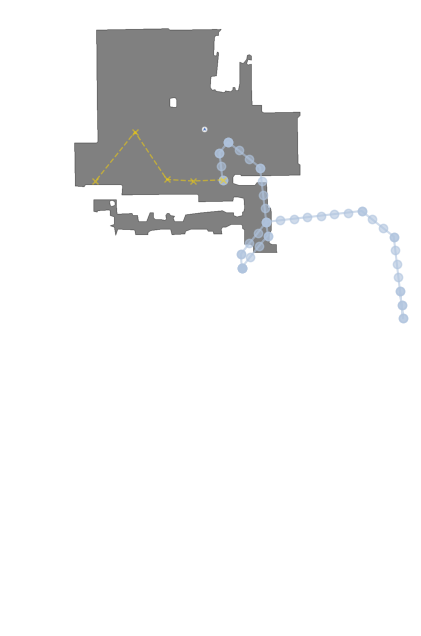

In [143]:
# Investigating a particularly interesting scan and annotation
scan_id = 'QUCTc6BB5sX'
instruction_id = 63289
try:
    print(df_results.loc[(scan_id, instruction_id)])
except:
    scan_id = df_results.index[0][0]
    instruction_id = df_results.index[0][1]
    print(df_results.loc[(scan_id, instruction_id)])

print(f'Investigating:')
print(f'scan_id: {scan_id}')
print(f'instruction_id: {instruction_id}')

# Displaying the map and trajectory achieved (vs gold path)
show_trajectory(scan_id, instruction_id, outputs[scan_id][instruction_id]["agent_states"],
                outputs[scan_id][instruction_id]["annotation_path"])

Instructions:
you begin in a kitchen, in front of you is a little serving island or a prepping island. if you turn
your body to the left you see a sink, another sink on another prepping island. and in between those
two prepping islands there is a walk way, in front of you should be a cabinet area. walk up that
cabinet area, turn your body to the right and you should see two, three archways. you are going to
go through the middle and the tallest archway. turn your body to the left until you are looking out
into the dining room. you are going to take a step forward into the dining room in between the
dining areas. once you are in between the two dining areas, to your right there should be a oval
glass table with a couch and two chairs. to your left should be a full on dining table. once you're
there you are done.

Starting Point: Standing in the kitchen facing a serving/prepping island.

Checkpoint 1: Turn your body to the left to face the sink area.

Checkpoint 2: Walk forward along the

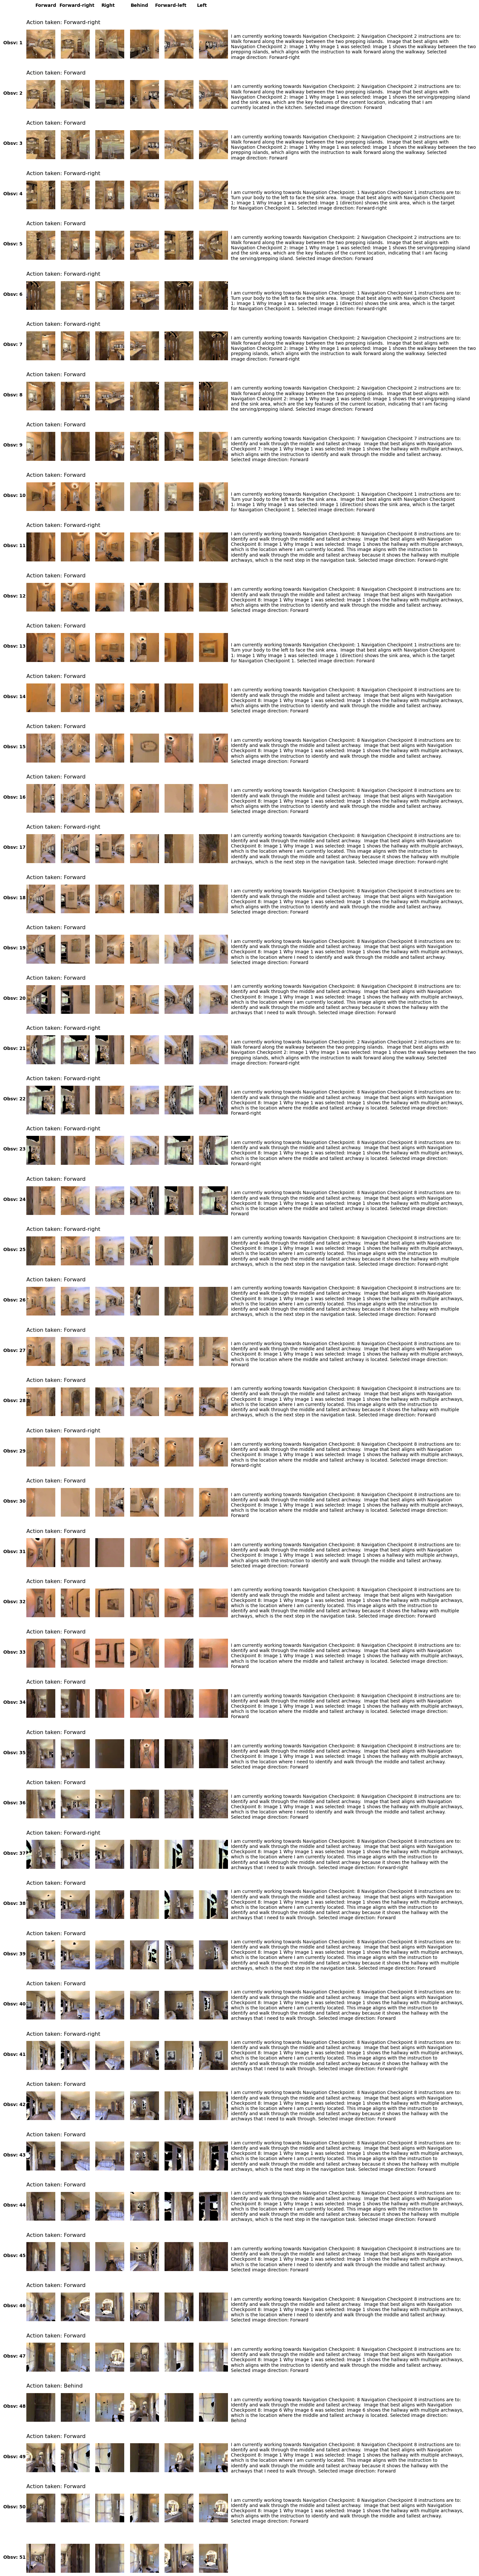

In [144]:
# Looking more closely into a single trajectory
for annotation in testing_rxr_annotations[scan_id]:
    if annotation['instruction_id'] == instruction_id:
        instruction = annotation['instruction']
print('Instructions:')
print(textwrap.fill(instruction, 100) + '\n')
print(outputs[scan_id][instruction_id]['inferred_nav_instructions'])

draw_trajectory_observations(outputs[scan_id][instruction_id]['observations'],
                             outputs[scan_id][instruction_id]['actions'],
                             outputs[scan_id][instruction_id]['reasoning']
                             )